# Import librairies

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
pip install chart_studio numpy pandas matplotlib joblib keras tensorflow scikit-learn plotly seaborn statsmodels scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Pré-processamento dos dados

* Carregando os dados
* Padronizando os dados
* Dividindo em treino, teste e validação

In [5]:
dataframe = pd.read_csv('dataframe.csv')

In [6]:
dataframe.head(5)

,TEMP
0,27.73
1,27.97
2,25.70
3,26.49
4,22.42


In [7]:
data = dataframe.values  # Converte o DataFrame para um array NumPy

## Train test split

In [8]:
# Definindo a proporção para treino, validação e teste
train_size = 0.7
valid_size = 0.15
test_size = 0.15

In [9]:
# Total de dados
total_data_len = len(dataframe)
train_data_len = int(np.floor(total_data_len * train_size))
valid_data_len = int(np.floor(total_data_len * valid_size))
print(total_data_len)
print(train_data_len)
print(valid_data_len)


564
394
84


### Criando Treino, Validacao e Teste sem Padronizacao dos dados

In [66]:
# Criando conjuntos de treinamento
train_data = data[0:train_data_len, :]
X_train, Y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(Y_train))
print(len(train_data))

334
334
394


In [67]:
# Criando o conjunto de validação
valid_data = data[train_data_len:train_data_len + valid_data_len, :]
X_valid, Y_valid = [], []

for i in range(60, len(valid_data)):
    X_valid.append(valid_data[i-60:i, 0])
    Y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_valid = np.array(Y_valid)

print(len(X_valid))
print(len(Y_valid))
print(len(valid_data))

24
24
84


In [68]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

86
86
146


### Treino, Teste e Validacao com padronizacao dos dados

In [10]:
# Criando o escalador
scaler = MinMaxScaler()


# Salvar o scaler para uso posterior
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [11]:
# Ajustar o scaler com base no conjunto de treinamento
train_data = data[0:train_data_len, :]  # Apenas dados de treino
train_data_scaled = scaler.fit_transform(train_data)  # Padronizando o conjunto de treino

# Criando os conjuntos de treinamento a partir dos dados padronizados
X_train, Y_train = [], []
for i in range(60, len(train_data_scaled)):
    X_train.append(train_data_scaled[i-60:i, 0])  # Sequência de 60 passos
    Y_train.append(train_data_scaled[i, 0])       # Próximo valor a ser previsto

# Convertendo para arrays NumPy
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Ajustando o formato de X_train para 3D, se necessário (séries temporais)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Verificando os tamanhos
print(f"Tamanhos: X_train={len(X_train)}, Y_train={len(Y_train)}, train_data={len(train_data)}")


Tamanhos: X_train=334, Y_train=334, train_data=394


In [33]:
# Criando o conjunto de validação
valid_data = data[train_data_len:train_data_len + valid_data_len, :]  # Dados de validação

# Padronizando o conjunto de validação com o escalador treinado no conjunto de treino
valid_data_scaled = scaler.transform(valid_data)  # Usando o mesmo escalador

# Criando as sequências para o conjunto de validação
X_valid, Y_valid = [], []
for i in range(60, len(valid_data_scaled)):
    X_valid.append(valid_data_scaled[i-60:i, 0])  # Sequência de 60 passos
    Y_valid.append(valid_data_scaled[i, 0])       # Próximo valor a ser previsto

# Convertendo para arrays NumPy
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

# Ajustando o formato de X_valid para 3D, se necessário
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

# Verificando os tamanhos
print(f"Tamanhos: X_valid={len(X_valid)}, Y_valid={len(Y_valid)}")

Tamanhos: X_valid=24, Y_valid=24


In [13]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = data[train_data_len + valid_data_len - 60:, :]  # Dados de teste

# Padronizando o conjunto de teste com o escalador ajustado no conjunto de treino
test_data_scaled = scaler.transform(test_data)  # Usando o mesmo escalador

# Criando as sequências para o conjunto de teste
X_test = []
for i in range(60, len(test_data_scaled)):
    X_test.append(test_data_scaled[i-60:i, 0])  # Sequência de 60 passos

X_test = np.array(X_test)

# Ajustando o formato de X_test para 3D, necessário para o modelo LSTM
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Definindo Y_test (valores reais do conjunto de teste)
Y_test = data[train_data_len + valid_data_len:, :]  # Isso permanece o mesmo

print(f"Tamanhos: X_test={len(X_test)}, Y_test={len(Y_test)}")
print(f"Tamanho de test_data: {len(test_data)}")

Tamanhos: X_test=86, Y_test=86
Tamanho de test_data: 146


In [35]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'Y_valid length: {len(Y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 334
Y_train length: 334
X_valid length: 24
Y_valid length: 24
X_test length: 86
Y_test length: 86


## Ajuste dos dados para os modelos LSTM e CNN

In [36]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (334, 60, 1)
Validation set shape (24, 60, 1)
Test set shape (86, 60, 1)


In [37]:
# def create_sequences(data, seq_length):
#     sequences = []
#     labels = []
#     for i in range(len(data) - seq_length):
#         sequence = data[i:i+seq_length]
#         label = data[i+seq_length]
#         sequences.append(sequence)
#         labels.append(label)
#     return np.array(sequences), np.array(labels)

# # Defina o comprimento da sequência
# seq_length = 30
# X_train_series, Y_train_series = create_sequences(scaled_data, seq_length)
# print('Train set shape', X_trains_series.shape)
# print('Validation set shape', X_valid.shape)
# print('Test set shape', X_test.shape)

# Funções de Métricas Utilizadas e Plot dos Resultados

In [19]:
# # Função para calcular MAPE
# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
# # Função para calcular MSE
# def mean_squared_error(y_true, y_pred):
#     return np.mean((y_true - y_pred) ** 2)


In [21]:
# # Função para calcular RMSE
# def root_mean_squared_error(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [22]:
# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)

    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100

    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")

    return mae, mse, rmse, mape

In [23]:
# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta

    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]

        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")

        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")

        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")

        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

In [24]:
def plot_multiple_loss(history_standard, history_reg, history_drop, history_reg_drop):

    # Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
    plt.figure(figsize=(14, 10))

    # Modelo Simples
    plt.subplot(2, 2, 1)
    plt.plot(history_standard.history['loss'], label='Treinamento')
    plt.plot(history_standard.history['val_loss'], label='Validação')
    plt.title('Modelo Simples: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Regularização
    plt.subplot(2, 2, 2)
    plt.plot(history_reg.history['loss'], label='Treinamento')
    plt.plot(history_reg.history['val_loss'], label='Validação')
    plt.title('Modelo com Regularização: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Dropout
    plt.subplot(2, 2, 3)
    plt.plot(history_drop.history['loss'], label='Treinamento')
    plt.plot(history_drop.history['val_loss'], label='Validação')
    plt.title('Modelo com Dropout: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Regularização e Dropout
    plt.subplot(2, 2, 4)
    plt.plot(history_reg_drop.history['loss'], label='Treinamento')
    plt.plot(history_reg_drop.history['val_loss'], label='Validação')
    plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [25]:
def plot_predicts(y_pred, y_pred_reg, y_pred_drop, y_pred_reg_drop):

    # Gráficos de predição
    plt.figure(figsize=(14, 10))

    # Modelo Simples
    plt.subplot(2, 2, 1)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred, label='Predito (Simples)', color='red')
    plt.title('Modelo Simples')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Regularização
    plt.subplot(2, 2, 2)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_reg, label='Predito (Reg)', color='red')
    plt.title('Modelo com Regularização')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Dropout
    plt.subplot(2, 2, 3)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_drop, label='Predito (Drop)', color='red')
    plt.title('Modelo com Dropout')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Regularização e Dropout
    plt.subplot(2, 2, 4)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_reg_drop, label='Predito (Reg + Drop)', color='red')
    plt.title('Modelo com Regularização e Dropout')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    plt.tight_layout()
    plt.show()

# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

### Selecao de Hiperparametros

In [38]:
epochs_mlp = 50
batch_mlp = 32
lr = 0.001

### Implementacao e ajuste do Modelo MLP

In [39]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(32))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp.summary()

In [40]:
#history_mlp = model_mlp.fit(X_train, Y_train,
#                            validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp = model_mlp.fit(X_train,
                            Y_train,
                            validation_data=(X_valid, Y_valid),
                            epochs=epochs_mlp,
                            batch_size=batch_mlp,
                            verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0966 - val_loss: 0.0274
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0542 - val_loss: 0.0203
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0384 - val_loss: 0.0219
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301 - val_loss: 0.0179
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0269 - val_loss: 0.0182
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0235 - val_loss: 0.0167
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0214 - val_loss: 0.0154
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0198 - val_loss: 0.0144
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 - val_loss: 0.0134
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - val_loss: 0.0128
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 - val_loss: 0.0122
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0156 - val_

### Implementacao e Ajuste do Modelo MLP com regularização

In [41]:
model_mlp_reg = Sequential()
model_mlp_reg.add(Dense(64, activation='relu', input_dim=X_train.shape[1],
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(32, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(1))  # Saída
model_mlp_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_reg.summary()

In [42]:
#history_mlp_reg = model_mlp_reg.fit(X_train, Y_train,
#                           validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp_reg = model_mlp_reg.fit(X_train,
                                    Y_train,
                                    validation_data=(X_valid, Y_valid),
                                    epochs=epochs_mlp,
                                    batch_size=batch_mlp,
                                    verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.3462 - val_loss: 1.0557
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0254 - val_loss: 0.9367
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9220 - val_loss: 0.8572
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8435 - val_loss: 0.7885
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7753 - val_loss: 0.7216
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7121 - val_loss: 0.6644
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6544 - val_loss: 0.6095
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6014 - val_loss: 0.5603
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5532 - val_loss: 0.5153
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5095 - val_loss: 0.4746
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4695 - val_loss: 0.4374
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4331 - val_l

### Implementacao e ajuste do modelo MLP com Dropout

In [43]:
model_mlp_drop = Sequential()
model_mlp_drop.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp_drop.add(Dropout(0.3))
model_mlp_drop.add(Dense(32, activation='relu'))
model_mlp_drop.add(Dropout(0.3))
model_mlp_drop.add(Dense(1))
model_mlp_drop.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_dropout.summary()



In [44]:
#history_mlp_drop = model_mlp_dropout.fit(X_train, Y_train,
#                            validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp_drop = model_mlp_drop.fit(X_train,
                                        Y_train,
                                        validation_data=(X_valid, Y_valid),
                                        epochs=epochs_mlp,
                                        batch_size=batch_mlp,
                                        verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.0940 - val_loss: 0.1170
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2635 - val_loss: 0.0882
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2168 - val_loss: 0.0764
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1458 - val_loss: 0.0611
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1096 - val_loss: 0.0430
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1109 - val_loss: 0.0477
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0832 - val_loss: 0.0506
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0843 - val_loss: 0.0466
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0940 - val_loss: 0.0566
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0704 - val_loss: 0.0473
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0764 - val_loss: 0.0378
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0620 - val_l

### Implementando e Ajustando modelo MLP com Regularização e Dropout

In [45]:
# Definição do modelo MLP com regularização e dropout
model_mlp_reg_drop = Sequential()
model_mlp_reg_drop.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))  # Taxa de dropout de 20%
model_mlp_reg_drop.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))
model_mlp_reg_drop.add(Dense(1))  # Camada de saída
model_mlp_reg_drop.compile(optimizer=optimizers.Adam(lr), loss='mse', metrics=['mae'])

In [46]:
history_mlp_reg_drop = model_mlp_reg_drop.fit(X_train,
                                              Y_train,
                                              validation_data=(X_valid, Y_valid),
                                              epochs=epochs_mlp,
                                              batch_size=batch_mlp,
                                              verbose=1)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6459 - mae: 0.5674 - val_loss: 0.2432 - val_mae: 0.2437
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3041 - mae: 0.3050 - val_loss: 0.1976 - val_mae: 0.1889
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2256 - mae: 0.2276 - val_loss: 0.1559 - val_mae: 0.0885
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2059 - mae: 0.1955 - val_loss: 0.1643 - val_mae: 0.1267
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1926 - mae: 0.1857 - val_loss: 0.1564 - val_mae: 0.1216
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1874 - mae: 0.1801 - val_loss: 0.1451 - val_mae: 0.1021
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1727 - mae: 0.1638 - val_loss: 0.1513 - val_mae: 0.1291
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1619 - mae: 0.1548 - val_loss: 0.1424 - val_mae: 0.1189
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1564 - mae:

## Comparando os 4 modelos

In [47]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_mlp_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_mlp_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_mlp_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Modelo Padrão:
MAE: 24.5166
MSE: 605.9445
RMSE: 24.6159
MAPE: 97.8368%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Modelo com Regularização:
MAE: 24.5236
MSE: 606.3149
RMSE: 24.6235
MAPE: 97.8624%


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Modelo com Dropout:
MAE: 24.5657
MSE: 608.5457
RMSE: 24.6687
MAPE: 98.0166%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Modelo com Regularização e Dropout:
MAE: 24.5337
MSE: 606.7845
RMSE: 24.6330
MAPE: 97.9049%


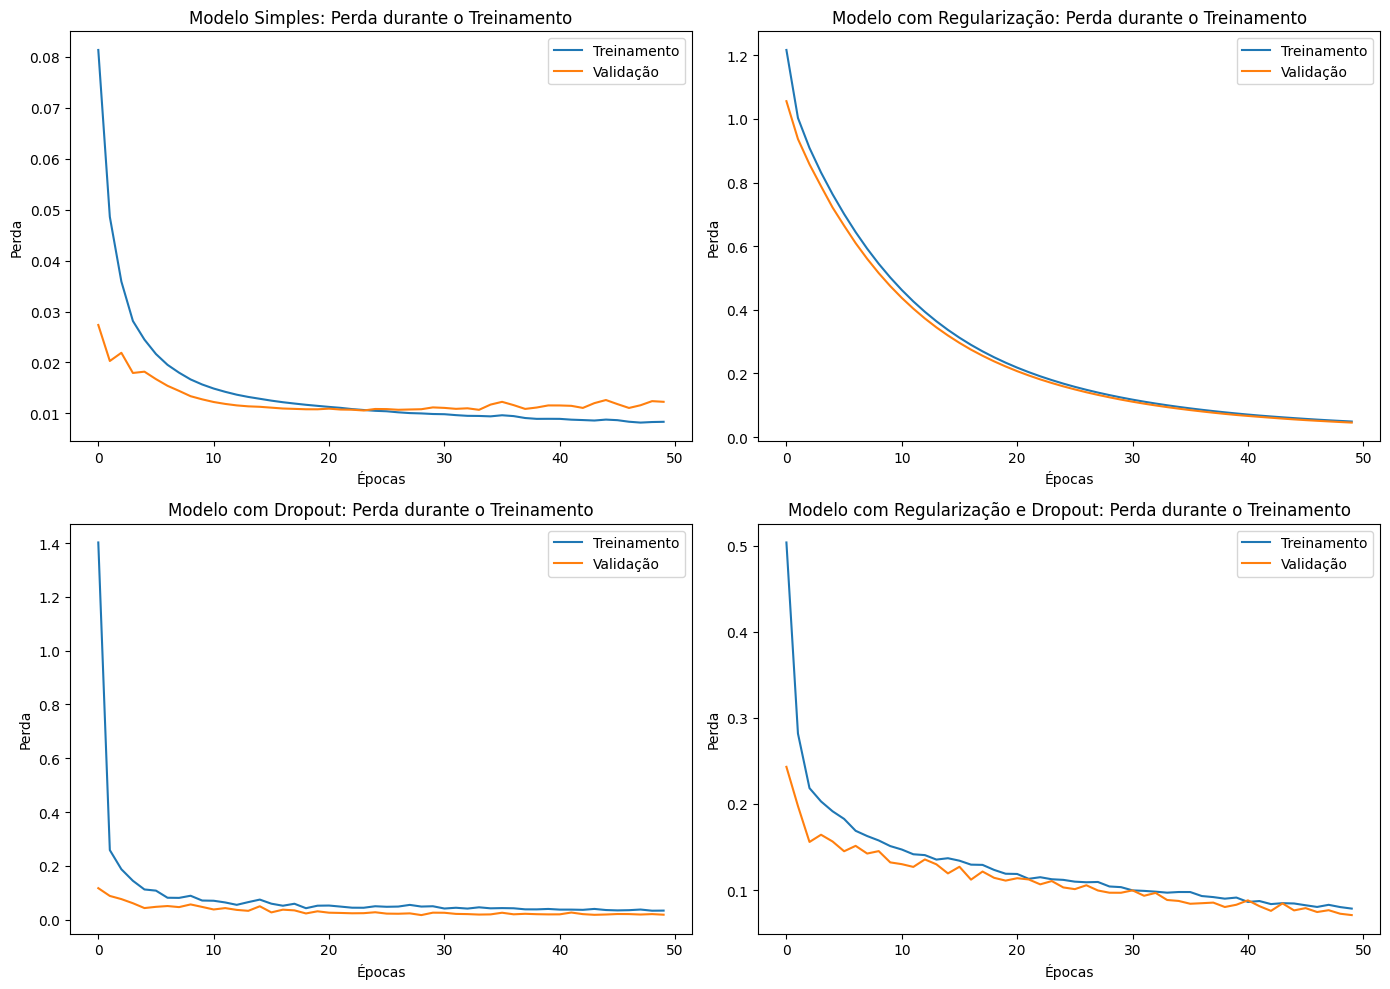

In [48]:
#Plot do Grafico de Perda
plot_multiple_loss(history_mlp, history_mlp_reg, history_mlp_drop, history_mlp_reg_drop)

In [49]:
# Gerando previsões para cada modelo
y_pred_mlp = model_mlp.predict(X_test)
y_pred_mlp_reg = model_mlp_reg.predict(X_test)
y_pred_mlp_drop = model_mlp_drop.predict(X_test)
y_pred_mlp_reg_drop = model_mlp_reg_drop.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


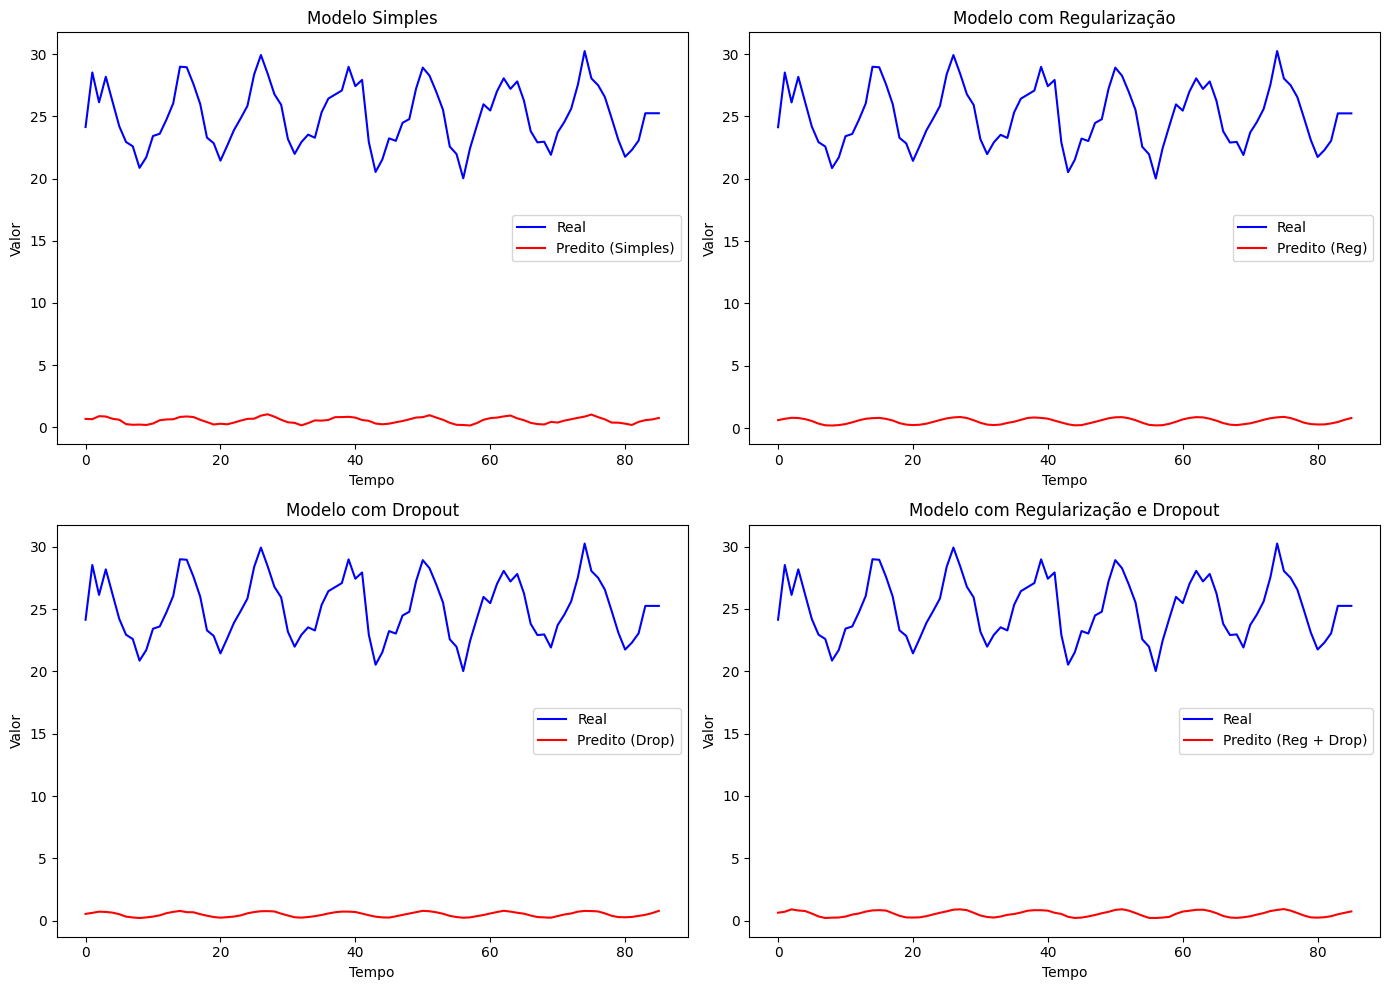

In [50]:
plot_predicts(y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop)

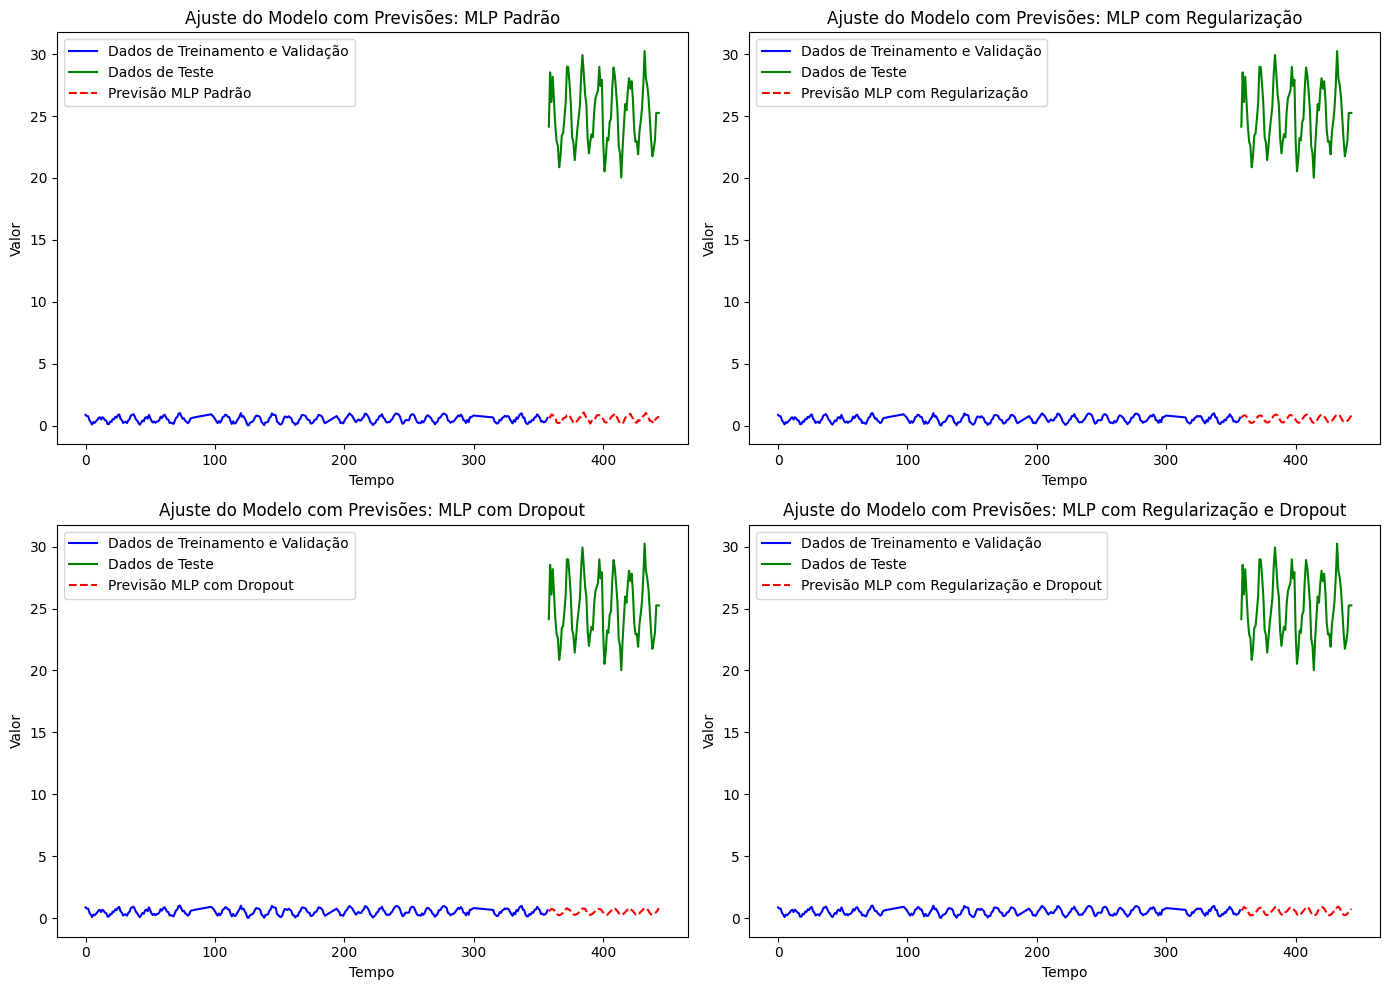

In [51]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop]
model_names = ["MLP Padrão", "MLP com Regularização", "MLP com Dropout", "MLP com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)


# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

## Seleção de Hiperparametros

In [52]:
#Hiperparametros
epochs_cnn = 30
batch_cnn = 32
lr_cnn = 0.001
#adam = optimizers.Adam(lr)


## Implementando e Ajustando Modelo CNN

In [53]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn.summary()

In [54]:
#history_cnn = model_cnn.fit(X_train_series, Y_train,
#                            validation_data=(X_valid_series, Y_valid),
#                            epochs=epochs_cnn,
#                            verbose=2)

history_cnn = model_cnn.fit(X_train,
                            Y_train,
                            validation_data=(X_valid, Y_valid),
                            epochs=epochs_cnn,
                            batch_size=batch_cnn,
                            verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1435 - val_loss: 0.0432
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0339 - val_loss: 0.0150
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0222 - val_loss: 0.0166
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0213 - val_loss: 0.0126
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0180 - val_loss: 0.0118
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0175 - val_loss: 0.0118
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0174 - val_loss: 0.0111
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0167 - val_loss: 0.0101
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0161 - val_loss: 0.0095
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0157 - val_loss: 0.0091
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0153 - val_loss: 0.0087
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0149 - val_l

## Implementando e Ajustando Modelo CNN com Regularização L2

In [55]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_reg.summary()


In [56]:
#history_cnn_reg = model_cnn_reg.fit(X_train_series, Y_train,
#                            validation_data=(X_valid_series, Y_valid),
#                            epochs=epochs_cnn,
#                            verbose=2)

history_cnn_reg = model_cnn_reg.fit(X_train_series,
                                    Y_train,
                                    validation_data=(X_valid_series, Y_valid),
                                    epochs=epochs_cnn,
                                    batch_size=batch_cnn,
                                    verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.0207 - val_loss: 0.6890
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6294 - val_loss: 0.4580
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4259 - val_loss: 0.3167
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2986 - val_loss: 0.2325
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2218 - val_loss: 0.1791
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1742 - val_loss: 0.1442
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1431 - val_loss: 0.1197
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1206 - val_loss: 0.1015
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1031 - val_loss: 0.0874
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0895 - val_loss: 0.0758
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0785 - val_loss: 0.0664
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0694 

## Implementando e Ajustando Modelo CNN com Dropout

In [57]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(0.3))
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(50, activation='relu'))
model_cnn_drop.add(Dropout(0.3))
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam(lr))
# model_cnn_drop.summary()

In [58]:
#history_cnn_drop = model_cnn_drop.fit(X_train_series, Y_train,
#                                       validation_data=(X_valid_series, Y_valid),
#                                       epochs=epochs_cnn,
#                                       verbose=2)

history_cnn_drop = model_cnn_drop.fit(X_train_series,
                                    Y_train,
                                    validation_data=(X_valid_series, Y_valid),
                                    epochs=epochs_cnn,
                                    batch_size=batch_cnn,
                                    verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1156 - val_loss: 0.0159
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0366 - val_loss: 0.0143
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0341 - val_loss: 0.0150
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0365 - val_loss: 0.0171
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0308 - val_loss: 0.0133
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0289 - val_loss: 0.0120
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0288 - val_loss: 0.0117
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0290 - val_loss: 0.0115
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0302 - val_loss: 0.0148
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0305 - val_loss: 0.0105
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0255 - val_loss: 0.0122
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0269 - val_l

## Implementando e Ajustando Modelo CNN com Regularização e Dropout

In [59]:
model_cnn_reg_drop = Sequential()
model_cnn_reg_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg_drop.add(MaxPooling1D(pool_size=2))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Flatten())
model_cnn_reg_drop.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Dense(1))
model_cnn_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr))
# model_cnn_reg_drop.summary()

In [60]:
#history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series, Y_train,
#                                             validation_data=(X_valid_series, Y_valid),
#                                             epochs=epochs_cnn,
#                                             verbose=2)

history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series,
                                            Y_train,
                                            validation_data=(X_valid_series, Y_valid),
                                            epochs=epochs_cnn,
                                            batch_size=batch_cnn,
                                            verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.1495 - val_loss: 0.7416
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6966 - val_loss: 0.5182
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4947 - val_loss: 0.3671
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3650 - val_loss: 0.2822
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2821 - val_loss: 0.2278
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2342 - val_loss: 0.1936
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1974 - val_loss: 0.1645
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1757 - val_loss: 0.1439
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1565 - val_loss: 0.1272
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1407 - val_loss: 0.1131
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1229 - val_loss: 0.1012
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1

## Comparando os 4 Modelos CNN

In [61]:
# Previsões
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_reg = model_cnn_reg.predict(X_test)
y_pred_cnn_drop = model_cnn_drop.predict(X_test)
y_pred_cnn_reg_drop = model_cnn_reg_drop.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [62]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Modelo Padrão:
MAE: 24.4825
MSE: 604.2993
RMSE: 24.5825
MAPE: 97.6971%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Modelo com Regularização:
MAE: 24.5125
MSE: 605.7911
RMSE: 24.6128
MAPE: 97.8153%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Modelo com Dropout:
MAE: 24.4596
MSE: 603.1158
RMSE: 24.5584
MAPE: 97.6097%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Modelo com Regularização e Dropout:
MAE: 24.5136
MSE: 605.8892
RMSE: 24.6148
MAPE: 97.8154%


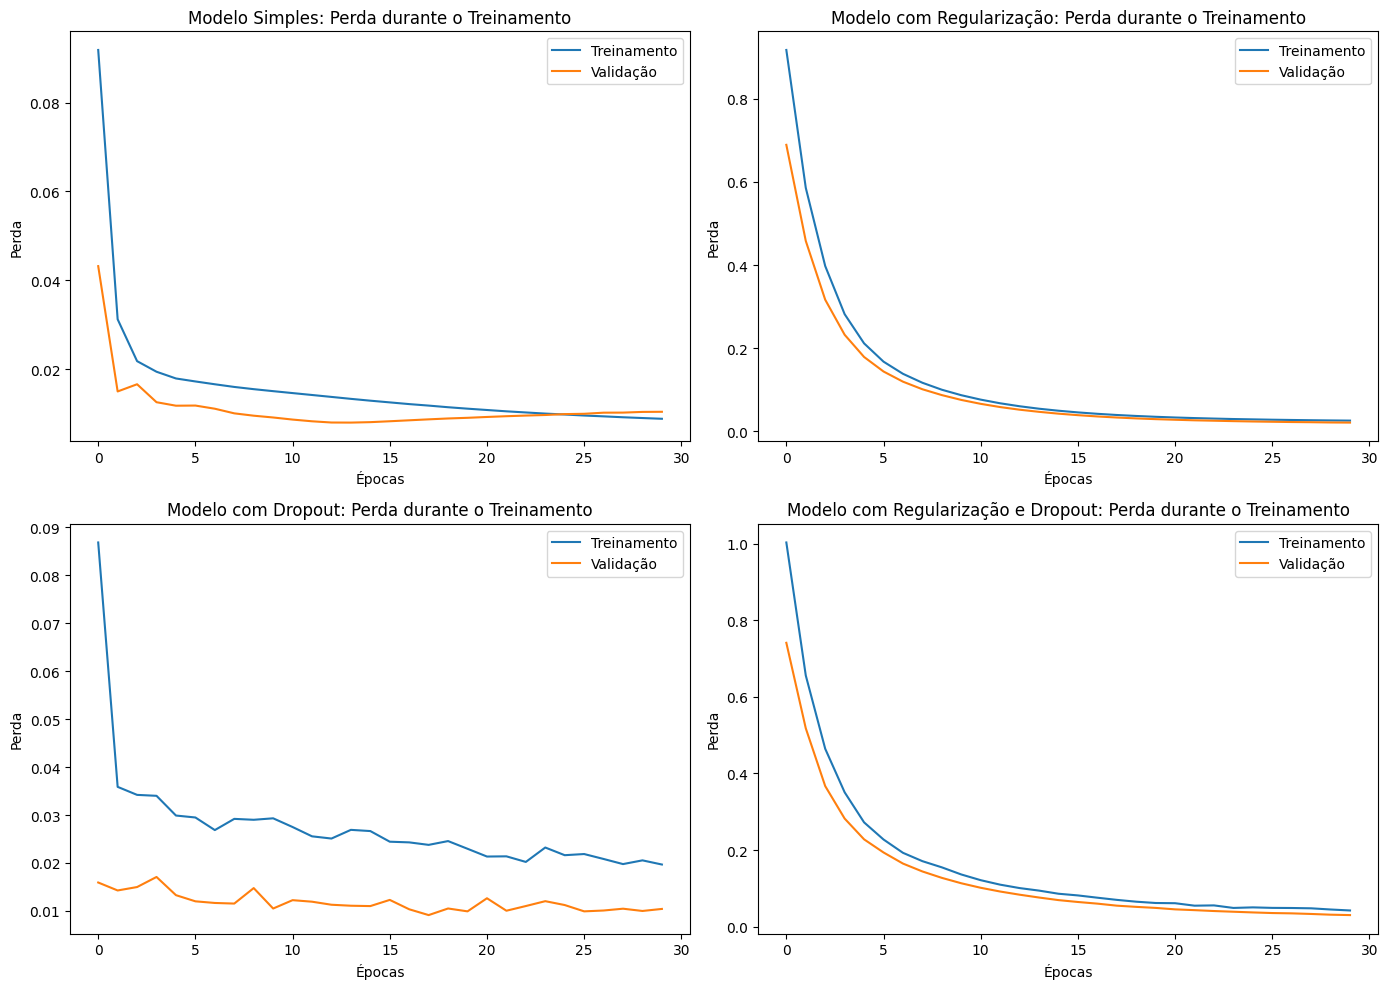

In [63]:
#Plot do Grafico de Perda
plot_multiple_loss(history_cnn, history_cnn_reg, history_cnn_drop, history_cnn_reg_drop)

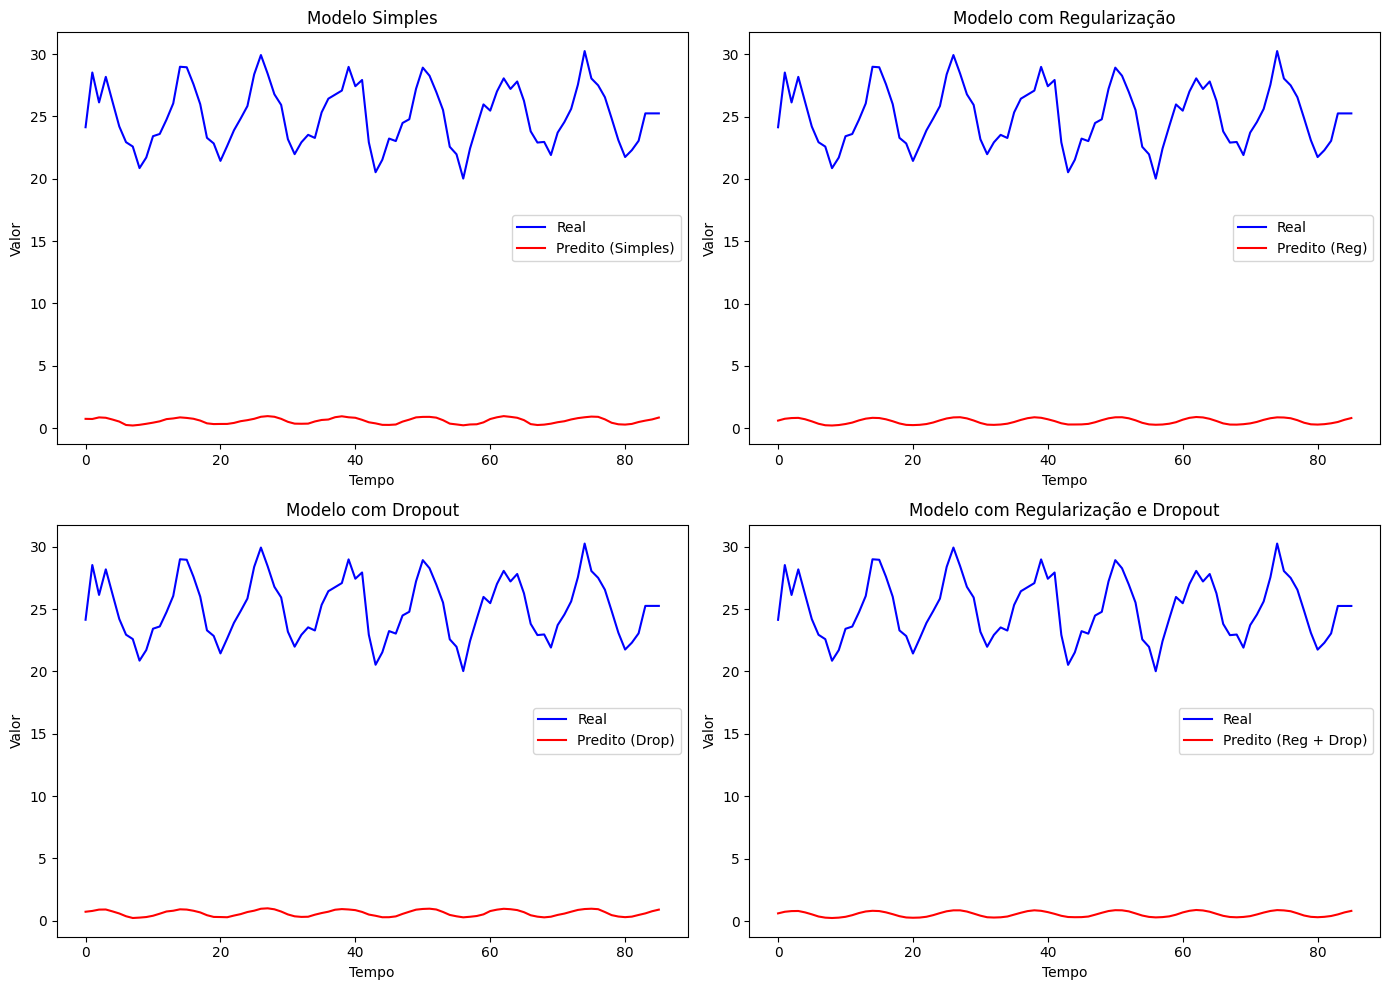

In [64]:
plot_predicts(y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop)

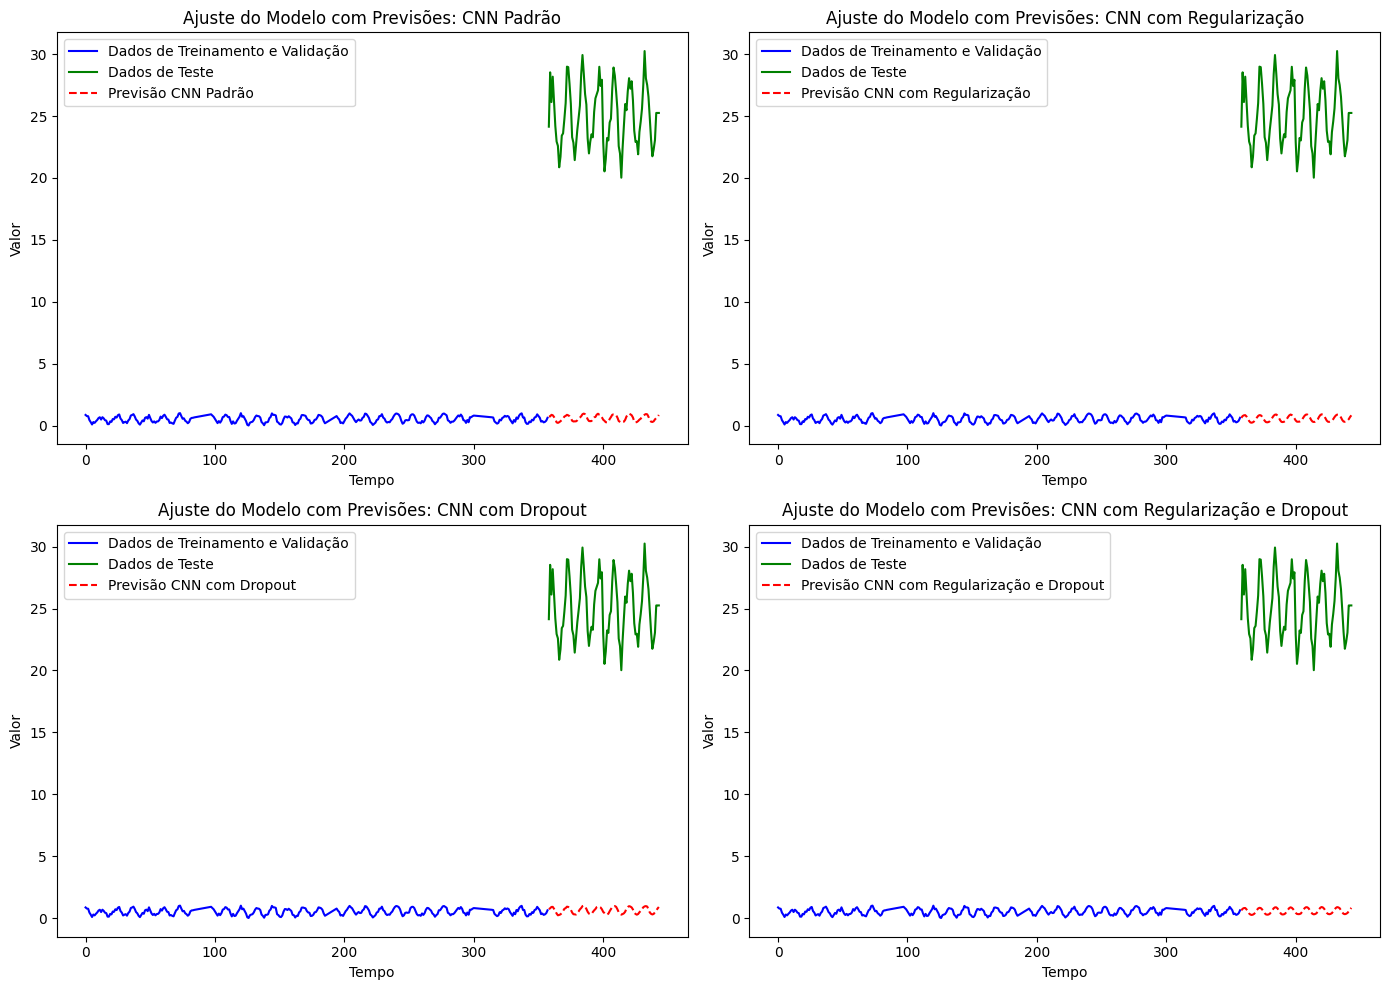

In [65]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop]
model_names = ["CNN Padrão", "CNN com Regularização", "CNN com Dropout", "CNN com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

## Pre-procesamento dos dados

In [ ]:
#Hiperparametros
epochs_lstm = 50
batch_lstm = 32
lr_lstm = 0.001

## Implementacao e Ajuste do Modelo LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm.summary()

In [ ]:
history_lstm = model_lstm.fit(X_train_series,
                              Y_train,
                              validation_data=(X_valid, Y_valid),
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)

## Implementacao e Ajuste do Modelo LSTM com Regularizacao L2

In [ ]:
model_lstm_reg = Sequential()
model_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_reg.add(Dense(1))
model_lstm_reg.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_reg.summary()


In [ ]:
# Treinamento do modelo com regularização L2
# history_lstm_reg = model_lstm_reg.fit(X_train_series,
#                                       y_train,
#                                       epochs=epochs_lstm,
#                                       batch_size=32,
#                                       validation_split= 0.15,
#                                       verbose=2)

history_lstm_reg = model_lstm_reg.fit(X_train_series,
                              Y_train,
                              validation_data=(X_valid, Y_valid),
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)


## Implementacao e Ajuste do Modelo LSTM com Dropout

In [ ]:
model_lstm_drop = Sequential()
model_lstm_drop.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_drop.add(Dropout(0.3))
model_lstm_drop.add(Dense(1))
model_lstm_drop.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_dropout.summary()


In [ ]:
# Treinamento do modelo com Dropout
history_lstm_drop = model_lstm_drop.fit(X_train_series,
                                              Y_train,
                                              epochs=epochs_lstm,
                                              batch_size=batch_lstm,
                                              validation_data=(X_valid, Y_valid),
                                              verbose=1)


## Implementacao e Ajuste do Modelo LSTM com Regularizacao e Dropout

In [ ]:
model_lstm_reg_drop = Sequential()
model_lstm_reg_drop.add(
    LSTM(
        50,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    )
)
model_lstm_reg_drop.add(Dropout(0.3))
model_lstm_reg_drop.add(Dense(1))
model_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm_reg_dropout.summary()


In [ ]:
history_lstm_reg_drop = model_lstm_reg_drop.fit(X_train_series,
                            Y_train,
                            epochs=epochs_lstm,
                            batch_size=batch_lstm,
                            validation_data=(X_valid, Y_valid),
                            verbose=2)

# history_lstm_drop = model_lstm_drop.fit(X_train_series,
#                                               Y_train,
#                                               epochs=epochs_lstm,
#                                               batch_size=32,
#                                               validation_data=(X_valid_series, Y_valid),
#                                               verbose=1)

## Comparativo entre os modelos - Predicao e Validacao

In [ ]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_lstm, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_lstm_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_lstm_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_lstm_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")

In [ ]:
#Plot do Grafico de Perda
plot_multiple_loss(history_lstm, history_lstm_reg, history_lstm_drop, history_lstm_reg_drop)

In [ ]:
# Obtendo as previsões dos quatro modelos
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_reg = model_lstm_reg.predict(X_test)
y_pred_lstm_drop = model_lstm_drop.predict(X_test)
y_pred_lstm_reg_drop = model_lstm_reg_drop.predict(X_test)

In [ ]:
plot_predicts(y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop)

In [ ]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop]
model_names = ["LSTM Padrão", "LSTM com Regularização", "LSTM com Dropout", "LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

## Pre-processamento dos dados

In [ ]:
#Hiperparametros
epochs_hibrid = 30
batch_hibrid = 32
lr_hibrid = 0.001
subsequences = 2

In [ ]:
timesteps = X_train.shape[1]//subsequences
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test.reshape((X_test.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)
print('Test set shape', X_test_series_sub.shape)

## Implementacao e ajuste do modelo padrao

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [ ]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_series_sub,
                                      Y_train,
                                      validation_data=(X_valid_series_sub, Y_valid),
                                      epochs=epochs_hibrid,
                                      batch_size = batch_hibrid,
                                      verbose=1)

## Implementacao e Ajuste do modelo com Regularizacao

In [ ]:
model_cnn_lstm_reg = Sequential()
model_cnn_lstm_reg.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg.add(Dense(1))
model_cnn_lstm_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [ ]:
history_cnn_lstm_reg = model_cnn_lstm_reg.fit(X_train_series_sub,
                                              Y_train,
                                              validation_data=(X_valid_series_sub, Y_valid),
                                              epochs=epochs_hibrid,
                                              batch_size = batch_hibrid,
                                              verbose=1)


## Implementacao e Ajuste do Modelo com Dropout

In [ ]:
model_cnn_lstm_drop = Sequential()
model_cnn_lstm_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(LSTM(50, activation='relu'))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(Dense(1))
model_cnn_lstm_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [ ]:
history_cnn_lstm_drop = model_cnn_lstm_drop.fit(X_train_series_sub,
                                                Y_train,
                                                validation_data=(X_valid_series_sub, Y_valid),
                                                epochs=epochs_hibrid,
                                                batch_size = batch_hibrid,
                                                verbose=1)


## Implementacao e Ajuste do Modelo com Regularizacao e Dropout

In [ ]:
model_cnn_lstm_reg_drop = Sequential()
model_cnn_lstm_reg_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(Dense(1))
model_cnn_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

history_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.fit(X_train_series_sub,
                                                        Y_train,
                                                        validation_data=(X_valid_series_sub, Y_valid),
                                                        epochs=epochs_hibrid,
                                                        batch_size = batch_hibrid,
                                                        verbose=1)


## Comparativo entre os modelos

In [ ]:
# Realizando previsões para cada modelo
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_series_sub)
y_pred_cnn_lstm_reg = model_cnn_lstm_reg.predict(X_test_series_sub)
y_pred_cnn_lstm_drop = model_cnn_lstm_drop.predict(X_test_series_sub)
y_pred_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.predict(X_test_series_sub)


In [ ]:
# # Cálculo das métricas para cada modelo
# metrics = {
#     "Modelo LSTM": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm)
#     },
#     "Modelo LSTM com Regularização": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg)
#     },
#     "Modelo LSTM com Dropout": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_drop),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_drop),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_drop)
#     },
#     "Modelo LSTM com Regularização e Dropout": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg_drop),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop)
#     }
# }

# # Exibir as métricas
# for model, values in metrics.items():
#     print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}")

In [ ]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn_lstm, X_test_series_sub, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_lstm_reg, X_test_series_sub, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_lstm_drop, X_test_series_sub, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_lstm_reg_drop, X_test_series_sub, Y_test, "Modelo com Regularização e Dropout")

In [ ]:
#Plot do Grafico de Perda
plot_multiple_loss(history_cnn_lstm, history_cnn_lstm_reg, history_cnn_lstm_drop, history_cnn_lstm_reg_drop)

In [ ]:
plot_predicts(y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop)

In [ ]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop]
model_names = ["CNN-LSTM Padrão", "CNN-LSTM com Regularização", "CNN-LSTM com Dropout", "CNN-LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)